In [1]:
pip install tensorflow

In [2]:
import os
import json

In [5]:
kaggle_credentails = json.load(open("kaggle (1).json"))

In [6]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [7]:
!kaggle datasets download ameencaslam/3body-filtered-v2-10k

Dataset URL: https://www.kaggle.com/datasets/ameencaslam/3body-filtered-v2-10k
License(s): unknown


In [8]:
import zipfile
import os

# Define paths
zip_file_path = "/content/3body-filtered-v2-10k.zip"  # Change to your actual file path
extract_folder = "/content/extracted_folder"  # Folder where files will be extracted

# Ensure the extraction folder exists
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:  # ✅ Ensure zipfile.ZipFile is used
    zip_ref.extractall(extract_folder)

print("Extraction completed. Extracted files:", os.listdir(extract_folder))

Extraction completed. Extracted files: ['real', 'fake']


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import os
import matplotlib.pyplot as plt

In [32]:
# Load and preprocess data
data_dir = '/content/extracted_folder'  # Replace with the path to your dataset
img_size = (224, 224)
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True  # Minimal augmentation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42  # Fix randomness for reproducibility
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False  # Critical for validation
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


Training InceptionV3...
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 145ms/step - accuracy: 0.6474 - loss: 0.7395 - val_accuracy: 0.7200 - val_loss: 0.5666 - learning_rate: 1.0000e-04
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 124ms/step - accuracy: 0.7530 - loss: 0.5269 - val_accuracy: 0.7918 - val_loss: 0.4584 - learning_rate: 1.0000e-04
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.7875 - loss: 0.4655 - val_accuracy: 0.7843 - val_loss: 0.4642 - learning_rate: 1.0000e-04
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 128ms/step - accuracy: 0.7965 - loss: 0.4439 - val_accuracy: 0.8067 - val_loss: 0.4265 - learning_rate: 1.0000e-04
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 151ms/step - accuracy: 0.8020 - loss: 0.4302 - val_accuracy: 0.8215 - val_loss: 0.4008 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 125ms/step - accuracy: 0.8168 - loss: 0.3982 - val_accuracy: 0.8260 - val_loss: 0.3948 - learning_rate: 1.0000e-04
Epoch 7/10
500/500 ━━━

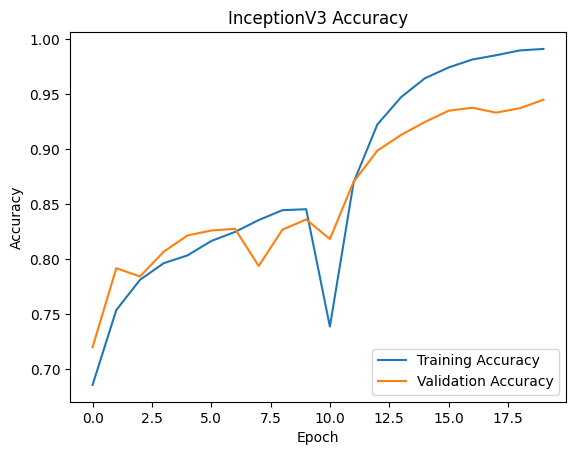

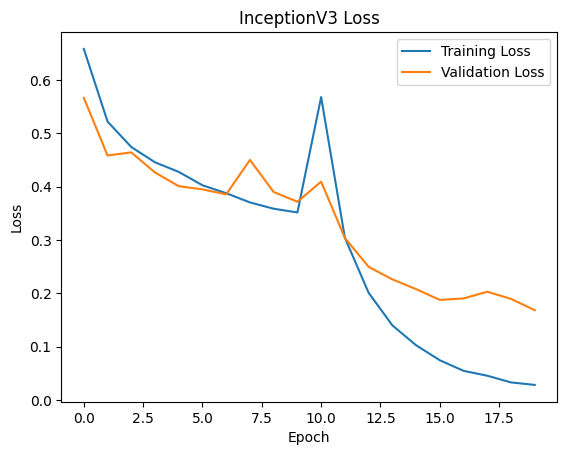

In [33]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the pretrained model function
def create_pretrained_model(base_model, num_classes=1):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    return model

# Callbacks for better training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model initially

# Create the model
model = create_pretrained_model(base_model)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("Training InceptionV3...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Fine-tune the model by unfreezing some layers
base_model.trainable = True
for layer in base_model.layers[:100]:  # Unfreeze the last few layers
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

print("Fine-tuning InceptionV3...")
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Save the model
model.save('InceptionV3_deepfake_model.h5')

# Plot training & validation accuracy
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


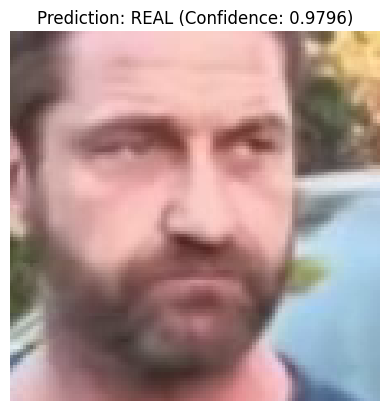

Prediction: REAL
Confidence: 0.9796


In [36]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the pre-trained model
model_path = 'final_deepfake_model.h5'  # Replace with the path to your saved model
model = tf.keras.models.load_model(model_path)

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Function to predict if the image is real or fake
def predict_image(img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Make prediction
    prediction = model.predict(img_array)
    confidence = prediction[0][0]  # Confidence score (0 = fake, 1 = real)

    # Determine if the image is real or fake
    if confidence > 0.5:
        result = "REAL"
    else:
        result = "FAKE"

    # Display the image and prediction
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result} (Confidence: {confidence:.4f})")
    plt.show()

    return result, confidence

# Path to the image you want to predict
image_path = '/content/Real_1.png'  # Replace with the path to your image

# Predict the image
result, confidence = predict_image(image_path)
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.4f}")

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Phase 1: Training top layers
Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.6928 - loss: 0.6869

500/500 ━━━━━━━━━━━━━━━━━━━━ 405s 662ms/step - accuracy: 0.6929 - loss: 0.6866 - val_accuracy: 0.8533 - val_loss: 0.3887 - learning_rate: 1.0000e-04
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8757 - loss: 0.3019

500/500 ━━━━━━━━━━━━━━━━━━━━ 312s 623ms/step - accuracy: 0.8758 - loss: 0.3018 - val_accuracy: 0.9053 - val_loss: 0.2302 - learning_rate: 1.0000e-04
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9208 - loss: 0.1986

500/500 ━━━━━━━━━━━━━━━━━━━━ 293s 587ms/step - accuracy: 0.9209 - loss: 0.1986 - val_accuracy: 0.9205 - val_loss: 0.2206 - learning_rate: 1.0000e-04
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9399 - loss: 0.1540

500/500 ━━━━━━━━━━━━━━━━━━━━ 304s 608ms/step - accuracy: 0.9399 - loss: 0.1540 - val_accuracy: 0.9408 - val_loss: 0.1535 - learning_rate: 1.0000e-04
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 295s 591ms/step - accuracy: 0.9519 - loss: 0.1227 - val_accuracy: 0.9227 - val_loss: 0.2043 - learning_rate: 1.0000e-04
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 290s 579ms/step - accuracy: 0.9596 - loss: 0.1076 - val_accuracy: 0.9107 - val_loss: 0.2924 - learning_rate: 1.0000e-04
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9596 - loss: 0.1057

500/500 ━━━━━━━━━━━━━━━━━━━━ 301s 602ms/step - accuracy: 0.9596 - loss: 0.1057 - val_accuracy: 0.9553 - val_loss: 0.1217 - learning_rate: 1.0000e-04
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 316s 633ms/step - accuracy: 0.9702 - loss: 0.0818 - val_accuracy: 0.9530 - val_loss: 0.1225 - learning_rate: 1.0000e-04
Epoch 9/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 292s 584ms/step - accuracy: 0.9714 - loss: 0.0772 - val_accuracy: 0.9415 - val_loss: 0.1860 - learning_rate: 1.0000e-04
Epoch 10/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 289s 578ms/step - accuracy: 0.9700 - loss: 0.0837 - val_accuracy: 0.9455 - val_loss: 0.1615 - learning_rate: 1.0000e-04
Epoch 11/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9779 - loss: 0.0539

500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 596ms/step - accuracy: 0.9779 - loss: 0.0539 - val_accuracy: 0.9795 - val_loss: 0.0599 - learning_rate: 2.0000e-05
Epoch 12/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 288s 576ms/step - accuracy: 0.9875 - loss: 0.0378 - val_accuracy: 0.9790 - val_loss: 0.0590 - learning_rate: 2.0000e-05
Epoch 13/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9895 - loss: 0.0276

500/500 ━━━━━━━━━━━━━━━━━━━━ 302s 604ms/step - accuracy: 0.9895 - loss: 0.0276 - val_accuracy: 0.9805 - val_loss: 0.0585 - learning_rate: 2.0000e-05
Epoch 14/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 292s 584ms/step - accuracy: 0.9898 - loss: 0.0226 - val_accuracy: 0.9805 - val_loss: 0.0575 - learning_rate: 2.0000e-05
Epoch 15/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 290s 580ms/step - accuracy: 0.9916 - loss: 0.0226 - val_accuracy: 0.9725 - val_loss: 0.0787 - learning_rate: 2.0000e-05
Phase 2: Fine-tuning
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9914 - loss: 0.0189

500/500 ━━━━━━━━━━━━━━━━━━━━ 331s 570ms/step - accuracy: 0.9914 - loss: 0.0189 - val_accuracy: 0.9810 - val_loss: 0.0622 - learning_rate: 1.0000e-05
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9921 - loss: 0.0190

500/500 ━━━━━━━━━━━━━━━━━━━━ 281s 562ms/step - accuracy: 0.9921 - loss: 0.0190 - val_accuracy: 0.9835 - val_loss: 0.0589 - learning_rate: 1.0000e-05
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9940 - loss: 0.0178

500/500 ━━━━━━━━━━━━━━━━━━━━ 278s 557ms/step - accuracy: 0.9940 - loss: 0.0178 - val_accuracy: 0.9840 - val_loss: 0.0523 - learning_rate: 1.0000e-05
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 271s 542ms/step - accuracy: 0.9945 - loss: 0.0141 - val_accuracy: 0.9795 - val_loss: 0.0681 - learning_rate: 1.0000e-05
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 270s 540ms/step - accuracy: 0.9938 - loss: 0.0145 - val_accuracy: 0.9815 - val_loss: 0.0624 - learning_rate: 1.0000e-05
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 269s 539ms/step - accuracy: 0.9927 - loss: 0.0171 - val_accuracy: 0.9840 - val_loss: 0.0586 - learning_rate: 1.0000e-05
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 272s 544ms/step - accuracy: 0.9945 - loss: 0.0146 - val_accuracy: 0.9805 - val_loss: 0.0612 - learning_rate: 2.0000e-06
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 271s 542ms/step - accuracy: 0.9949 - loss: 0.0121 - val_accuracy: 0.9822 - val_loss: 0.0588 - learning_rate: 2.0000e-06
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 407ms/step

Classi

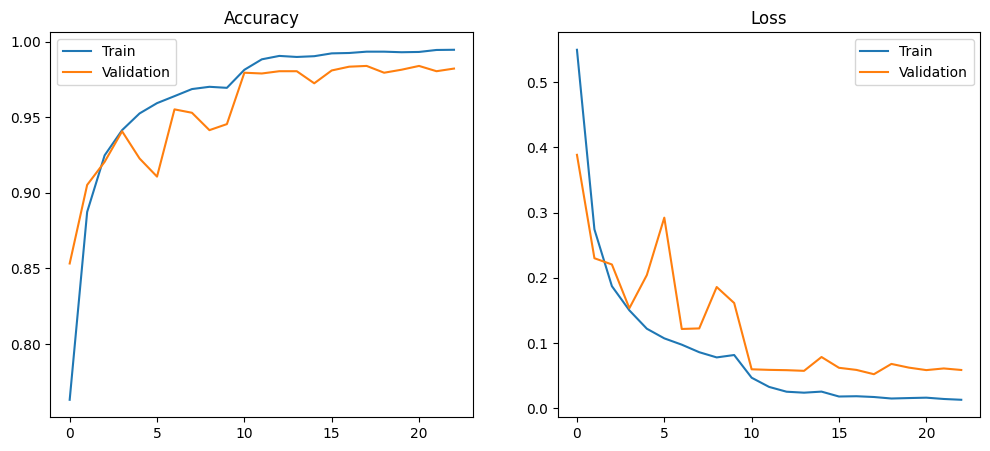

In [35]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Data Augmentation and Loading
data_dir = '/content/extracted_folder'  # Update this path
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Model Architecture
def create_pretrained_model():
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Model Training
model = create_pretrained_model()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
print("Phase 1: Training top layers")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

# Fine-tuning
model.layers[0].trainable = True
for layer in model.layers[0].layers[:100]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Phase 2: Fine-tuning")
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Evaluation
val_generator.reset()
y_pred = model.predict(val_generator) > 0.5
y_true = val_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

# Save final model
model.save('final_deepfake_model.h5')